# EE 519 — Frequency-domain Analysis of Speech (Lectures 7-8)
## Notebook — Manual STFT + Inspect Specific Frames (by time)

---
## What you will do
1. Load a saved speech clip from your manifest.
2. Compute STFT (manual).
3. Plot spectrogram and **pick times of interest**.
4. Convert times → frame indices and plot **frame spectra**.
5. Save plots for your lab report.


### How to use Lecture 7 notebooks in-class (hands-on)
**Goal:** build intuition for STFT by repeatedly analyzing *your own* recordings under different window/hop choices.

**Workflow for the whole lecture**
1. Record multiple clips once (Notebook 7.0) and they are saved + registered in a manifest.
2. Every later notebook reuses the same recordings (no re-recording needed).
3. Always pick **meaningful time regions** (vowel middle, fricative middle, stop burst, silence) — not just the first frames.

**Where things are saved**
- Audio: `EE519_L7_Project/audio/`
- Figures: `EE519_L7_Project/figures/`
- Manifest: `EE519_L7_Project/manifest.json`

**Pro tip:** keep filenames consistent across the class:  
`vowel_a_soft`, `vowel_a_loud`, `sentence_fast`, `sentence_slow`, `fricative_s`, `stop_pa`, `silence_room`


### ✅ Clip checklist (quick self-check)
By the end of Notebook you should have **at least 8 clips** registered in your manifest:

**Required categories**
- **Vowel**: one steady vowel (e.g., /a/ or /i/) — *soft* and *loud*
- **Sentence**: one short sentence — *slow* and *fast*
- **Fricative**: sustained /s/ or /sh/
- **Stop**: repeated /pa pa pa/ or /ta ta ta/ (captures bursts + closures)
- **Silence**: 2–3 seconds of room silence

If you're missing any, record them now in 7.0 (it takes 2-3 minutes and makes later analysis much clearer).


## 0) Setup


#### 🎙️ Before you record: tips for clean data
- Sit ~15–25 cm from the mic.
- Avoid tapping the laptop/desk (low-frequency thumps).
- Record at least **2–3 seconds** per clip.
- For vowel: hold a steady pitch (don’t glide).
- For sentence: keep content the same across slow/fast versions.


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


In [1]:
import os, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq
from scipy.signal import get_window, chirp
from scipy.io import wavfile
from IPython.display import Audio, display

plt.rcParams["figure.figsize"] = (12, 3)
plt.rcParams["axes.grid"] = True

# ---------------------------
# Project folders (auto-create)
# ---------------------------
PROJECT_DIR = Path("EE519_L7_Project")
AUDIO_DIR   = PROJECT_DIR / "audio"
FIG_DIR     = PROJECT_DIR / "figures"
RESULTS_DIR = PROJECT_DIR / "results"
for d in [PROJECT_DIR, AUDIO_DIR, FIG_DIR, RESULTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

MANIFEST_PATH = PROJECT_DIR / "manifest.json"

def _to_float_mono(y):
    """Convert audio array to float32 mono in [-1, 1]."""
    y = np.asarray(y)
    if y.ndim == 2:
        y = y.mean(axis=1)
    if np.issubdtype(y.dtype, np.integer):
        y = y.astype(np.float32) / (np.iinfo(y.dtype).max + 1e-12)
    else:
        y = y.astype(np.float32)
    mx = np.max(np.abs(y)) + 1e-12
    if mx > 1.0:
        y = y / mx
    return y

def load_wav(path):
    fs, y = wavfile.read(path)
    return fs, _to_float_mono(y)

def save_wav(path, fs, y):
    """Save float audio in [-1,1] to 16-bit PCM WAV."""
    y16 = np.clip(y, -1.0, 1.0)
    y16 = (y16 * 32767).astype(np.int16)
    wavfile.write(str(path), fs, y16)

def play_audio(y, fs, label=None):
    if label:
        print(label)
    display(Audio(y, rate=fs))

def plot_waveform(y, fs, title="Waveform", tlim=None, save_as=None):
    t = np.arange(len(y)) / fs
    plt.figure(figsize=(12, 3))
    plt.plot(t, y, linewidth=1)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    if save_as is not None:
        out = FIG_DIR / save_as
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()

def mag_spectrum(y, fs, nfft=None, db=True):
    y = np.asarray(y, dtype=np.float32)
    if nfft is None:
        nfft = int(2**np.ceil(np.log2(len(y))))
    Y = fft(y, n=nfft)
    f = fftfreq(nfft, d=1/fs)
    idx = f >= 0
    mag = np.abs(Y[idx])
    if db:
        mag = 20*np.log10(mag + 1e-10)
    return f[idx], mag

def plot_spectrum(y, fs, title="Magnitude Spectrum", fmax=None, nfft=None, db=True, save_as=None):
    f, mag = mag_spectrum(y, fs, nfft=nfft, db=db)
    plt.figure(figsize=(12, 3))
    plt.plot(f, mag, linewidth=1)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)" if db else "Magnitude")
    plt.title(title)
    if fmax is not None:
        plt.xlim(0, fmax)
    if save_as is not None:
        out = FIG_DIR / save_as
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()

def rms(y):
    y = np.asarray(y, dtype=np.float32)
    return float(np.sqrt(np.mean(y**2) + 1e-12))

def add_white_noise(y, snr_db, seed=0):
    rng = np.random.default_rng(seed)
    y = np.asarray(y, dtype=np.float32)
    sig_pwr = np.mean(y**2) + 1e-12
    noise_pwr = sig_pwr / (10**(snr_db/10))
    noise = rng.standard_normal(len(y), dtype=np.float32) * np.sqrt(noise_pwr)
    return y + noise

def select_segment(y, fs, start_s, end_s):
    s = int(start_s*fs); e = int(end_s*fs)
    s = max(0, min(s, len(y)))
    e = max(0, min(e, len(y)))
    if e <= s:
        raise ValueError("end_s must be > start_s and within signal duration.")
    return y[s:e]

# ---------------------------
# Recording utilities
# ---------------------------
SOUNDDEVICE_OK = False
try:
    import sounddevice as sd
    SOUNDDEVICE_OK = True
except Exception:
    SOUNDDEVICE_OK = False

def record_audio(seconds=3.0, fs=16000, channels=1):
    if not SOUNDDEVICE_OK:
        raise RuntimeError("sounddevice not available. Upload WAVs or install sounddevice locally.")
    print(f"Recording {seconds:.1f}s at {fs} Hz... (speak now)")
    y = sd.rec(int(seconds*fs), samplerate=fs, channels=channels, dtype='float32')
    sd.wait()
    y = _to_float_mono(y)
    print("Done. RMS:", rms(y))
    return fs, y

def load_manifest():
    if MANIFEST_PATH.exists():
        return json.loads(MANIFEST_PATH.read_text(encoding="utf-8"))
    return {"audio_clips": [], "notes": []}

def save_manifest(m):
    MANIFEST_PATH.write_text(json.dumps(m, indent=2), encoding="utf-8")

def register_clip(name, path, fs, duration_s, tags=None, notes=""):
    m = load_manifest()
    m["audio_clips"].append({
        "name": name,
        "path": str(path),
        "fs": fs,
        "duration_s": float(duration_s),
        "tags": tags or [],
        "notes": notes
    })
    save_manifest(m)

def list_clips():
    m = load_manifest()
    if len(m["audio_clips"]) == 0:
        print("No clips registered yet.")
        return
    for i, c in enumerate(m["audio_clips"]):
        print(f"[{i}] {c['name']} | {c['duration_s']:.2f}s | fs={c['fs']} | tags={c['tags']} | file={c['path']}")


#### 🔧 Optional automated check (run anytime)
This cell reads your `manifest.json` and tells you what clip types you might be missing.


In [2]:
# Automated checklist (uses tags and/or names)
import json, re
from pathlib import Path

MANIFEST_PATH = Path("EE519_L7_Project/manifest.json")
if not MANIFEST_PATH.exists():
    print("No manifest found yet. Run Notebook 7.0 and record at least one clip.")
else:
    m = json.loads(MANIFEST_PATH.read_text(encoding="utf-8"))
    clips = m.get("audio_clips", [])
    names = [c.get("name","").lower() for c in clips]
    tags  = [set([t.lower() for t in c.get("tags",[])]) for c in clips]

    def has(pattern):
        rgx = re.compile(pattern)
        return any(rgx.search(n) for n in names)

    def has_tag(t):
        return any(t in tg for tg in tags)

    req = {
        "vowel (soft)": has("vowel") and (has("soft") or has_tag("soft")),
        "vowel (loud)": has("vowel") and (has("loud") or has_tag("loud")),
        "sentence (slow)": has("sentence") and (has("slow") or has_tag("slow")),
        "sentence (fast)": has("sentence") and (has("fast") or has_tag("fast")),
        "fricative": has("fric") or has("s_") or has_tag("fricative"),
        "stop/burst": has("stop") or has("pa") or has("ta") or has_tag("stop"),
        "silence": has("silence") or has_tag("silence"),
    }

    print("Manifest clips:", len(clips))
    missing = [k for k,v in req.items() if not v]
    if not missing:
        print("✅ Looks good — you have the recommended set.")
    else:
        print("⚠️ Missing (recommended):")
        for k in missing:
            print(" -", k)


Manifest clips: 12
⚠️ Missing (recommended):
 - vowel (loud)


#### 🔍 Before you run: what will change when you change window/hop?
- **Short window** → better **time** resolution, blurrier frequency (wideband look)
- **Long window** → better **frequency** resolution, blurrier time (narrowband look)
- **Smaller hop** → more overlap → smoother time evolution, more computation

**Common issues**
- If harmonics look “fuzzy”: increase window length (for narrowband).
- If stop bursts look “smeared”: shorten window (for wideband).


#### 🎯 Action: pick *meaningful* time points (not sequential frames)
Use the waveform/spectrogram to pick times from **different phenomena**:
- vowel middle
- fricative middle
- stop burst peak
- silence/closure

**Why?** You want to compare spectra across *sound types*, not across adjacent time slices.


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


In [3]:
def stft_manual(y, fs, win_length_ms=25, hop_ms=10, window="hann", nfft=None, center=False):
    """Manual STFT (analysis only). Returns f (Hz), t (s), X (frames x freqs), meta."""
    y = np.asarray(y, dtype=np.float32)
    N = int(round(win_length_ms * 1e-3 * fs))
    H = int(round(hop_ms * 1e-3 * fs))
    if N <= 0 or H <= 0:
        raise ValueError("Window length and hop must be positive.")
    if nfft is None:
        nfft = int(2**np.ceil(np.log2(N)))
    if nfft < N:
        raise ValueError("nfft must be >= N.")
    w = get_window(window, N, fftbins=True).astype(np.float32)
    if center:
        pad = N // 2
        y = np.pad(y, (pad, pad), mode="constant")
    num_frames = 1 + (len(y) - N) // H
    if num_frames <= 0:
        raise ValueError("Signal too short for chosen window length.")
    X = np.empty((num_frames, nfft//2 + 1), dtype=np.complex64)
    for m in range(num_frames):
        start = m * H
        frame = y[start:start+N] * w
        X[m, :] = np.fft.rfft(frame, n=nfft)
    f = np.fft.rfftfreq(nfft, d=1/fs)
    t = (np.arange(num_frames) * H) / fs
    meta = {"N": N, "H": H, "nfft": nfft, "window": window, "center": center,
            "win_length_ms": win_length_ms, "hop_ms": hop_ms}
    return f, t, X, meta

def spec_db(X):
    return 20*np.log10(np.abs(X) + 1e-10)

def plot_spectrogram_db(f, t, X, title="Spectrogram (dB)", fmax=None, vmin=None, vmax=None, save_as=None):
    S = spec_db(X)  # frames x freqs
    plt.figure(figsize=(12, 4.5))
    plt.imshow(S.T, origin="lower", aspect="auto",
               extent=[t[0], t[-1], f[0], f[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar(label="dB")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    if fmax is not None:
        plt.ylim(0, fmax)
    if save_as is not None:
        out = FIG_DIR / save_as
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()

def frame_index_from_time(t_sec, fs, hop_ms):
    H = int(round(hop_ms * 1e-3 * fs))
    return int(round(t_sec * fs / H))

def plot_frame_spectrum_from_stft(f, X, frame_idx, title="", fmax=None, save_as=None):
    mag_db = 20*np.log10(np.abs(X[frame_idx]) + 1e-10)
    plt.figure(figsize=(12,3))
    plt.plot(f, mag_db, linewidth=1)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title(title + f" (frame={frame_idx})")
    if fmax is not None:
        plt.xlim(0, fmax)
    if save_as is not None:
        out = FIG_DIR / save_as
        plt.savefig(out, dpi=160, bbox_inches="tight")
        print("Saved figure ->", out)
    plt.show()


---
## 1) Choose a clip from your manifest


#### ✅ Checkpoint: choose clips you can explain
Pick clips where you can point to regions like:
- steady **vowel** (voiced)  
- sustained **/s/** (unvoiced)  
- **stop burst** (brief)  
- **silence/closure** (low energy)

**In-class goal:** you should be able to say “this region is voiced/unvoiced/stop/silence” *before* plotting.


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


[0] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project/audio/vowel_a_normal.wav
[1] sentence_normal | 4.00s | fs=16000 | tags=['voiced', 'sentence', 'normal'] | file=EE519_L7_Project/audio/sentence_normal.wav
[2] vowel_a_normal | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'normal'] | file=EE519_L7_Project\audio\vowel_a_normal.wav
[3] vowel_a_soft | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'soft'] | file=EE519_L7_Project\audio\vowel_a_soft.wav
[4] vowel_a_soft | 4.00s | fs=16000 | tags=['voiced', 'vowel', 'soft'] | file=EE519_L7_Project\audio\vowel_a_soft.wav
[5] sentence_slow | 4.00s | fs=16000 | tags=['voiced', 'sentence', 'slow'] | file=EE519_L7_Project\audio\sentence_slow.wav
[6] sentence_fast | 4.00s | fs=16000 | tags=['voiced', 'sentence', 'fast'] | file=EE519_L7_Project\audio\sentence_fast.wav
[7] fricative | 4.00s | fs=16000 | tags=['unvoiced', 'fricative'] | file=EE519_L7_Project\audio\fricative.wav
[8] stop | 4.00s | fs=16000 | t

Saved figure -> EE519_L7_Project\figures\L7_2_sentence_normal_waveform.png


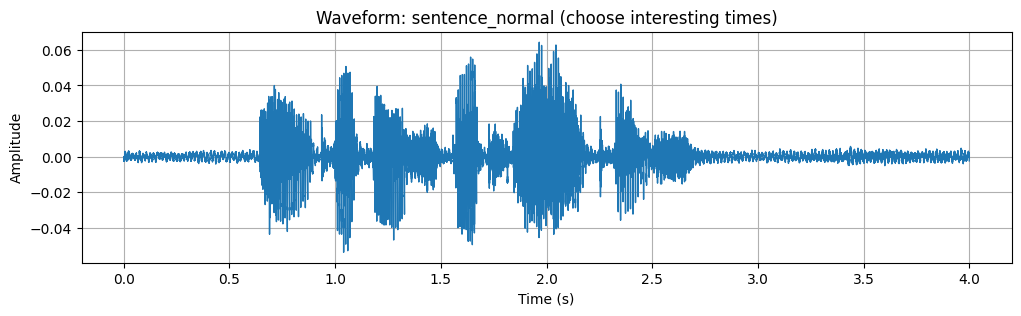

In [5]:
list_clips()
clip_index = 1  # TODO: pick a clip (try vowel, fricative, sentence)

m = load_manifest()
if len(m["audio_clips"]) > clip_index:
    c = m["audio_clips"][clip_index]
    fs, y = load_wav(c["path"])
    print("Using clip:", c["name"], "| tags:", c["tags"])
    play_audio(y, fs, label=c["name"])
    plot_waveform(y, fs, title=f"Waveform: {c['name']} (choose interesting times)", save_as=f"L7_2_{c['name']}_waveform.png")
else:
    raise RuntimeError("No such clip index. Record/register clips first.")


---
## 2) Compute STFT (manual)
Default speech settings:
- win=30 ms, hop=10 ms, Hann, nfft=1024

**Before running:** predict what voiced vs unvoiced will look like in the spectrogram.


In [6]:
win_ms, hop_ms, nfft = 30, 10, 1024
f, tt, X, meta = stft_manual(y, fs, win_length_ms=win_ms, hop_ms=hop_ms, window="hann", nfft=nfft, center=True)
meta


{'N': 480,
 'H': 160,
 'nfft': 1024,
 'window': 'hann',
 'center': True,
 'win_length_ms': 30,
 'hop_ms': 10}

#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


Saved figure -> EE519_L7_Project\figures\L7_2_sentence_normal_spec.png


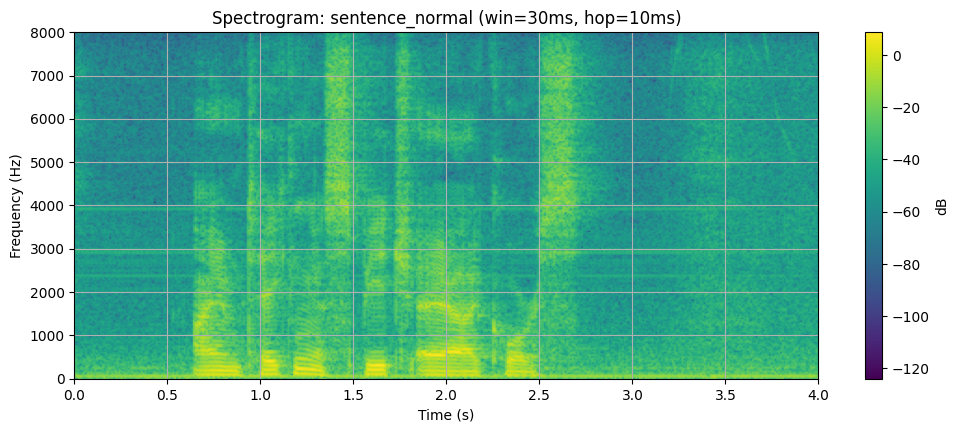

In [7]:
plot_spectrogram_db(f, tt, X,
                    title=f"Spectrogram: {c['name']} (win={win_ms}ms, hop={hop_ms}ms)",
                    fmax=min(8000, fs/2),
                    save_as=f"L7_2_{c['name']}_spec.png")


Saved figure -> EE519_L7_Project\figures\L7_2_sentence_normal_spec.png


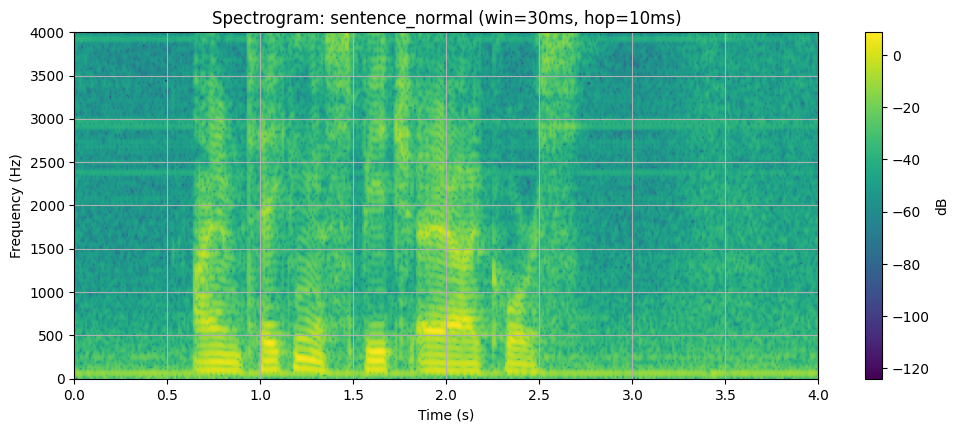

In [8]:
plot_spectrogram_db(f, tt, X,
                    title=f"Spectrogram: {c['name']} (win={win_ms}ms, hop={hop_ms}ms)",
                    fmax=min(4000, fs/4),
                    save_as=f"L7_2_{c['name']}_spec.png")

---
## 3) Pick times of interest and inspect frame spectra
### How to choose times
Look at waveform + spectrogram and choose times for:
- voiced (vowel)
- unvoiced (fricative)
- silence
- burst / onset (if present)

Then we convert time → frame index and plot frame spectra.


#### 🎯 Action: pick *meaningful* time points (not sequential frames)
Use the waveform/spectrogram to pick times from **different phenomena**:
- vowel middle
- fricative middle
- stop burst peak
- silence/closure

**Why?** You want to compare spectra across *sound types*, not across adjacent time slices.


#### 💾 Save your artifacts
Saving plots helps you build a personal “speech atlas” you can review before exams/projects.
If your saved figures folder is empty, check:
- you ran the plotting cell
- the notebook has write permission in the current folder


Saved figure -> EE519_L7_Project\figures\L7_2_sentence_normal_frameSpec_t0p70ppng


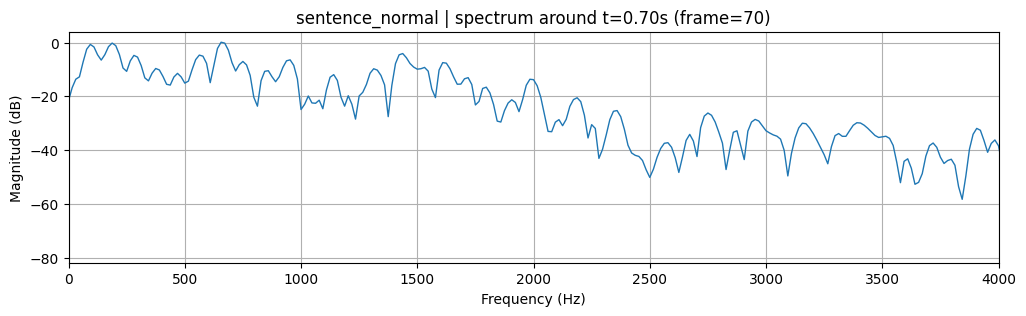

Saved figure -> EE519_L7_Project\figures\L7_2_sentence_normal_frameSpec_t2p30ppng


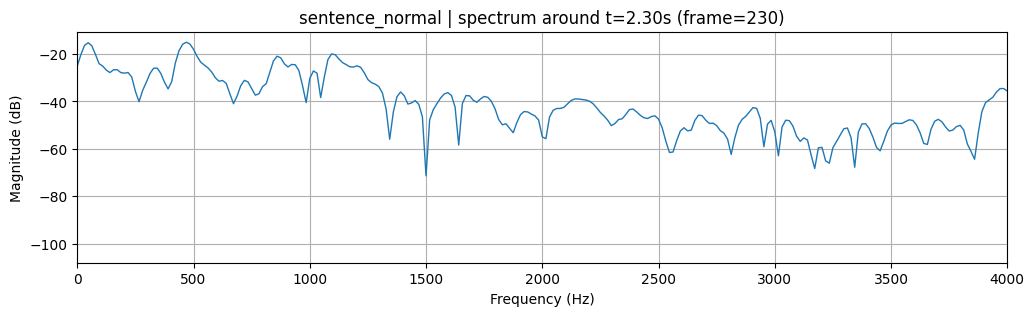

Saved figure -> EE519_L7_Project\figures\L7_2_sentence_normal_frameSpec_t2p50ppng


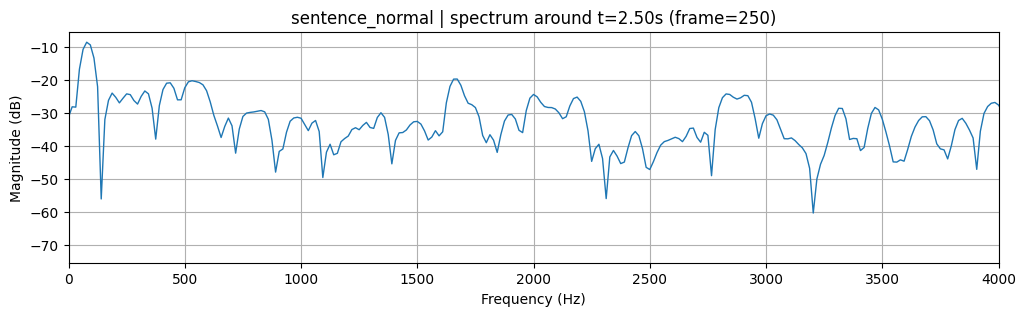

In [9]:
# TODO: edit these times (seconds) based on what you see
times_of_interest_s = [0.7, 2.3, 2.5]  

for t0 in times_of_interest_s:
    k = frame_index_from_time(t0, fs, hop_ms)
    k = max(0, min(k, X.shape[0]-1))
    plot_frame_spectrum_from_stft(
        f, X, k,
        title=f"{c['name']} | spectrum around t={t0:.2f}s",
        fmax=min(4000, fs/2),
        save_as=f"L7_2_{c['name']}_frameSpec_t{t0:.2f}.png".replace(".","p")
    )


### Quick check ✅
- Voiced frame: do you see harmonic peaks?
- Unvoiced frame: do you see broadband energy?
- Silence: is overall magnitude low?

If not:
- pick better times (or a better clip)
- try different window lengths (Notebook 7.3)


---
## 4) Summary + what’s next
Write in sentences:
1) What did you learn about voiced/unvoiced from spectrogram + frame spectra?
2) What was hard (choosing times? seeing harmonics?)
3) What parameter would you tune next and why?



### Answers

1. The voiced sounds have harmonics that show on the spectrogram as little lines in yellow towards the bottom. This differs from the alternatively colored and saturated unvoiced regions.
2. I had a hard time spotting harmonics at first but I see them towards the bottom of the spectrogram now.
3. Next I would try to tune the window size so I could see the impacts on the spectrogram.

---
## ✅ End-of-notebook wrap-up 
**Reflection (write in sentences):**
- What parameter change produced the *biggest visible difference* today?
- Which plot helped you most: waveform, spectrum, or spectrogram — and why?
- Name one mistake you made (or could make) and how you would debug it.

**What’s next:** proceed to the next Lecture notebook and reuse the same saved recordings.


### Answers

- The hop made a difference and shouldn't be larger than the window size.
- The spectrogram helped the most so I could spot harmonics in the voiced regions.
- I made a mistake and tried to plot the wrong parts of the signals so I fixed it by rerunning the cells and starting over.